# Model interpretability

In [2]:
#!pip install lightgbm
#!pip install pandas
#!pip install matplotlib
#!pip install scikit-learn
#!pip install seaborn
#!pip install numpy==2.2
#!pip install shap 
#!pip install joblib

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
import shap
import joblib

sns.set_style('whitegrid')

C:\Users\Nadiia\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

In [5]:
est = LGBMClassifier(objective='multiclass', class_weight='balanced', learning_rate=0.06, max_depth=2, n_estimators=100, num_leaves=4, verbose=-1)

final_model = est.fit(X_train, y_train.to_numpy().ravel())

In [6]:
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78       100
           1       0.56      0.44      0.50        61
           2       0.24      0.37      0.29        30
           3       0.37      0.32      0.34        34
           4       0.00      0.00      0.00         5

    accuracy                           0.54       230
   macro avg       0.40      0.38      0.38       230
weighted avg       0.59      0.54      0.56       230



Text(0, 0.5, 'Number of Patients')

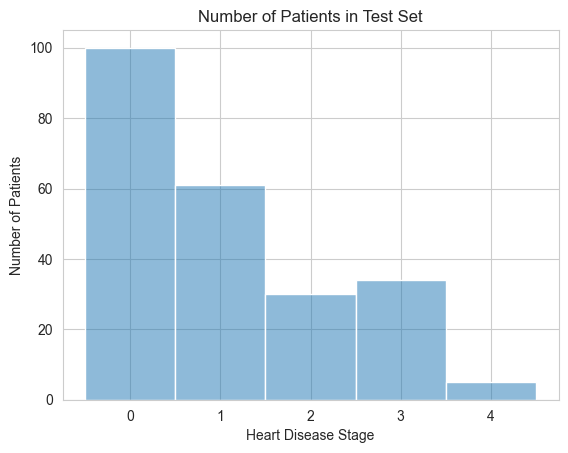

In [7]:
sns.histplot(y_test, discrete=True, legend=False)
plt.title('Number of Patients in Test Set')
plt.xlabel('Heart Disease Stage')
plt.ylabel('Number of Patients')

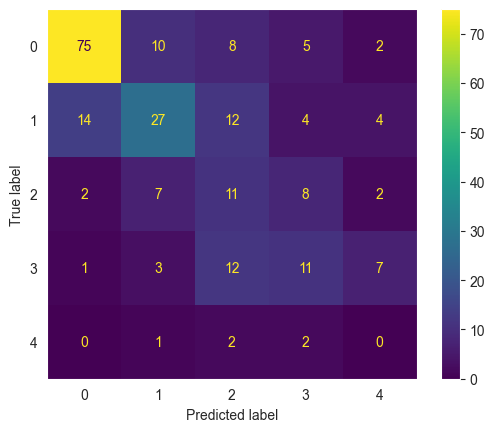

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sns.set_style('dark')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

# healthy people - actual 75+10+8+5+2=100, predicted 75 (true negative)
# healthy, but predicted ill - 25 (false positive)
# ill people, but predicted healthy - 14+2+1=17 (false negative)
# all other ill - 113 (true positive)

<Axes: title={'center': 'LightGBM Feature Importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

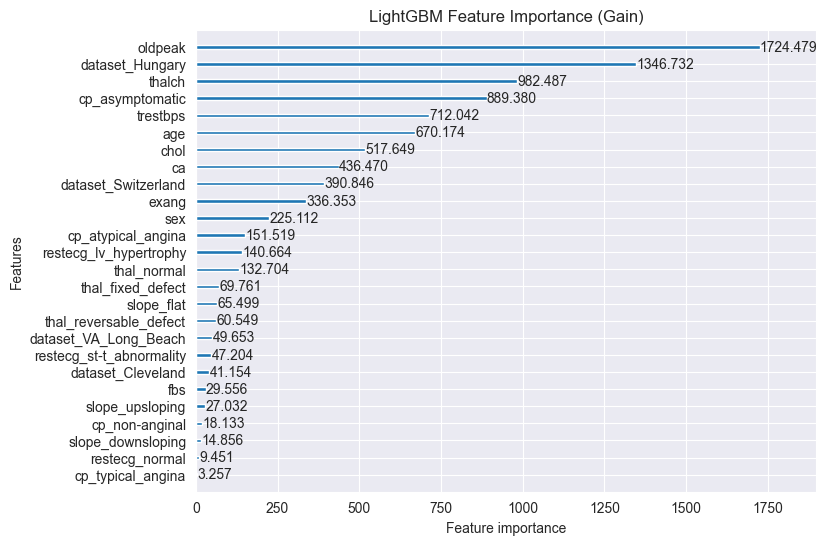

In [9]:
lgb.plot_importance(final_model, importance_type='gain', figsize=(8, 6), title='LightGBM Feature Importance (Gain)')

<Axes: title={'center': 'LightGBM Feature Importance (Split)'}, xlabel='Feature importance', ylabel='Features'>

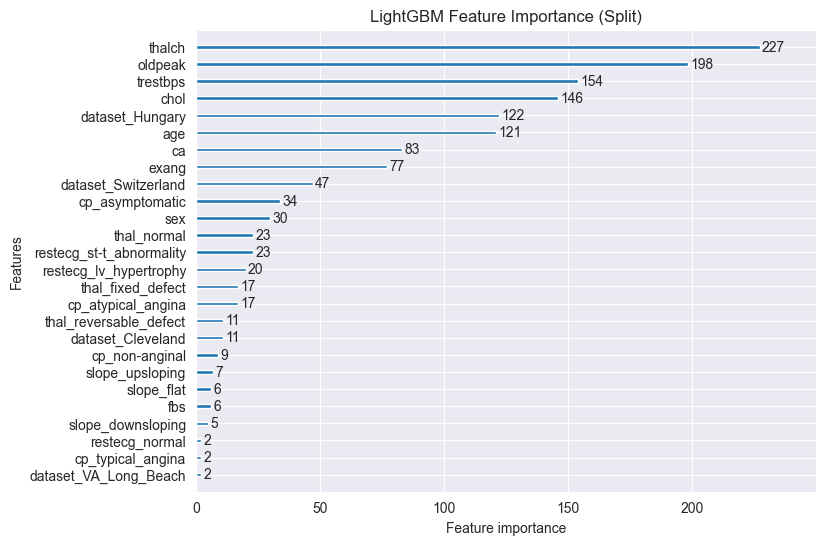

In [10]:
lgb.plot_importance(final_model, importance_type='split', figsize=(8, 6), title='LightGBM Feature Importance (Split)')

In [11]:
shap.initjs()

explainer = shap.Explainer(final_model)
shap_values = explainer(X_train)

shap_values.shape

(690, 26, 5)

In [12]:
# visualize one prediction's explanation
#shap.plots.waterfall(shap_values[17, :, 0])

In [13]:
# visualize one prediction's explanation with a force plot
#shap.plots.force(shap_values[17, :, 4])

In [14]:
# visualize the range of the training set predictions
# shap.plots.force(shap_values[:100, :, 4])

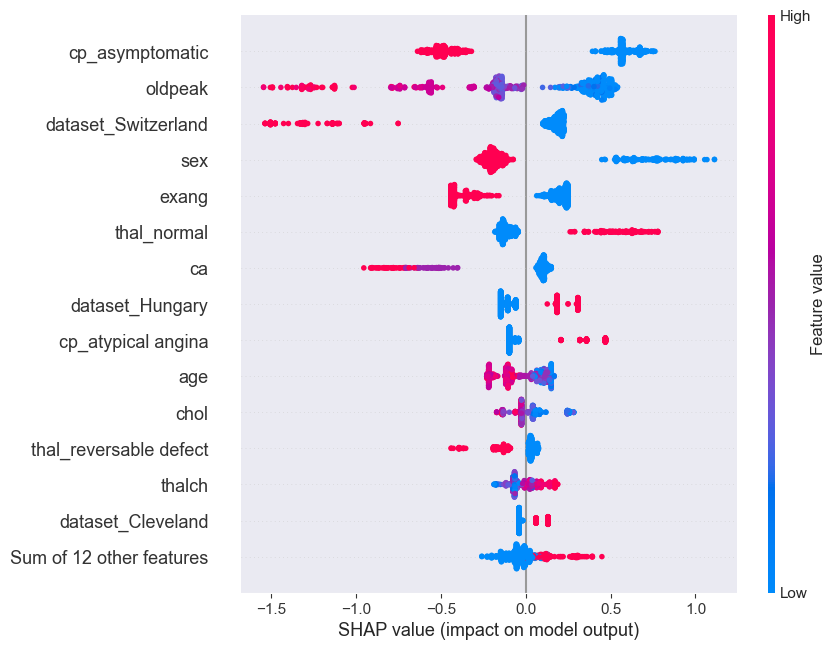

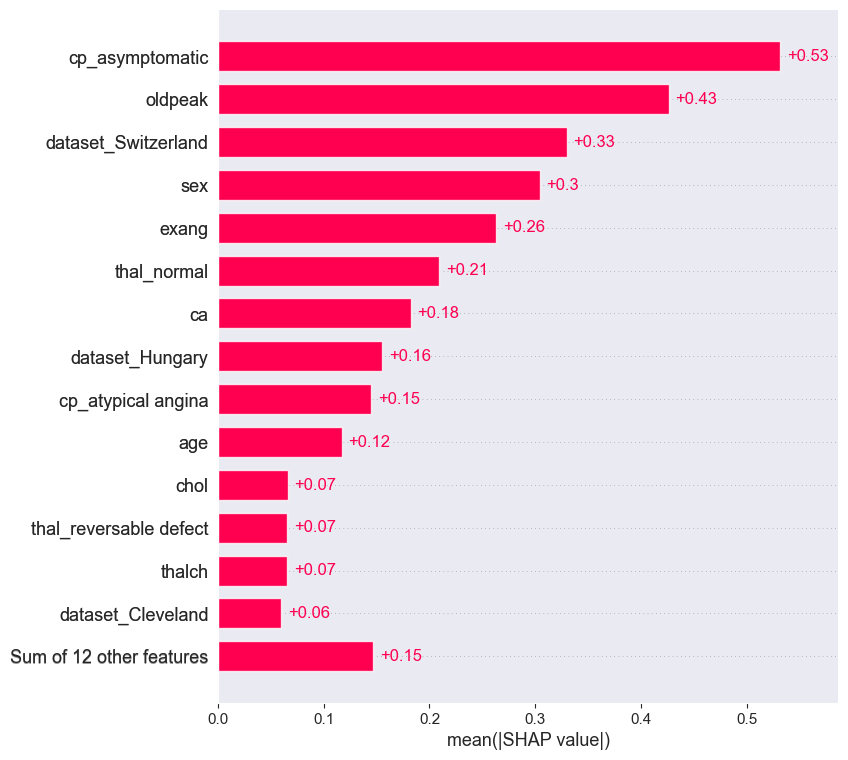

In [15]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values[:, :, 0], max_display=15)
# for example, high thal_normal shows that patient healthy, also low exang and low cp_asymptomatic

shap.plots.bar(shap_values[:, :, 0], max_display=15)

In [16]:
feature_names = X_test.columns

shap_mean_healthy = np.abs(shap_values[:, :, 0].values).mean(0)
feature_importance_healthy = [feature_names[i] for i in np.argsort(shap_mean_healthy)[::-1]]

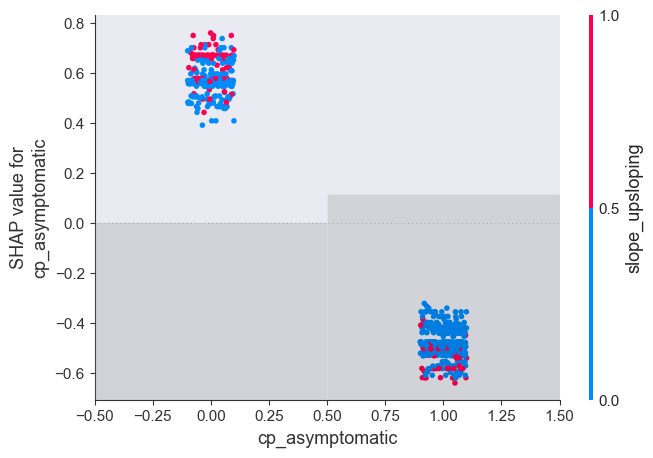

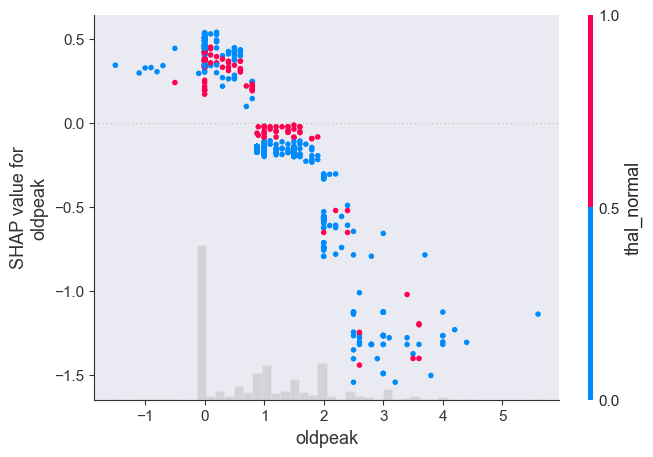

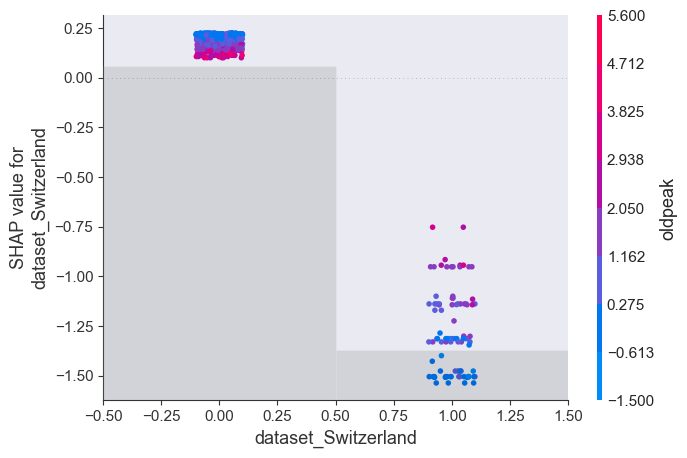

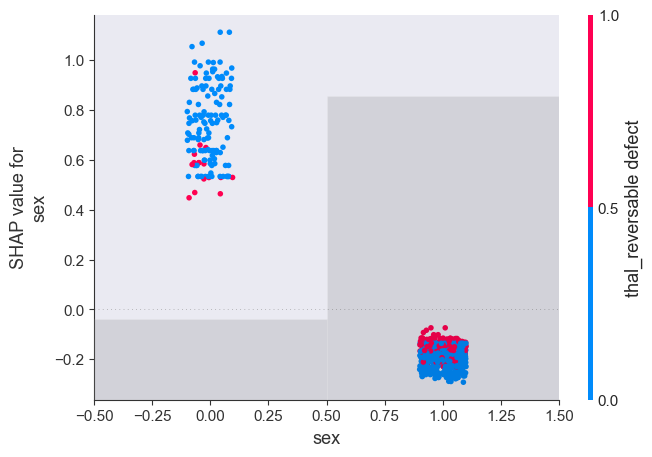

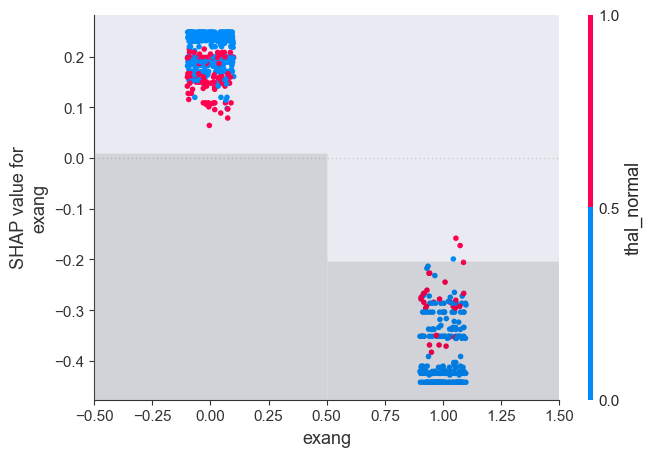

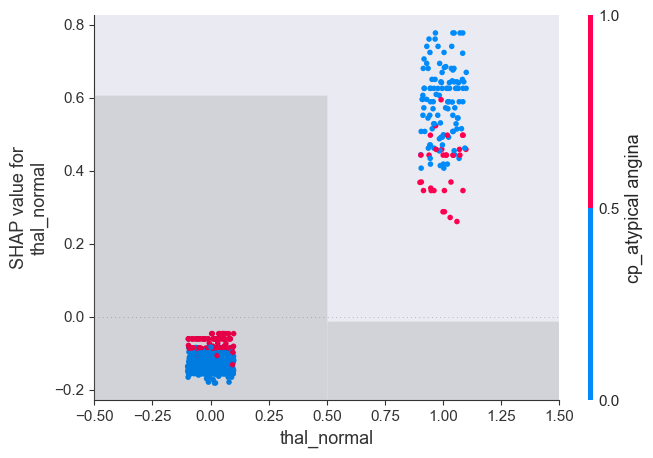

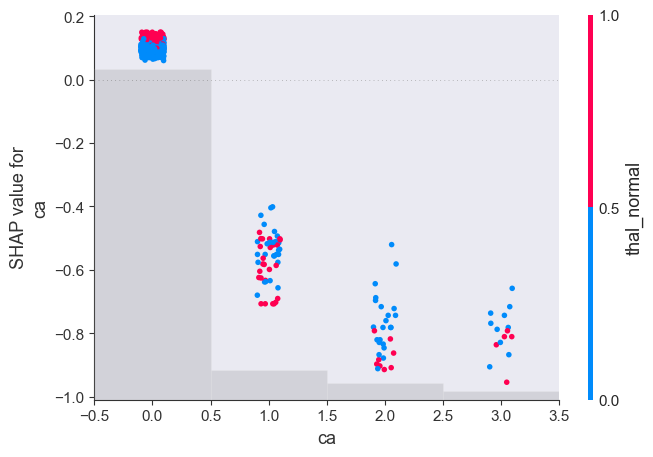

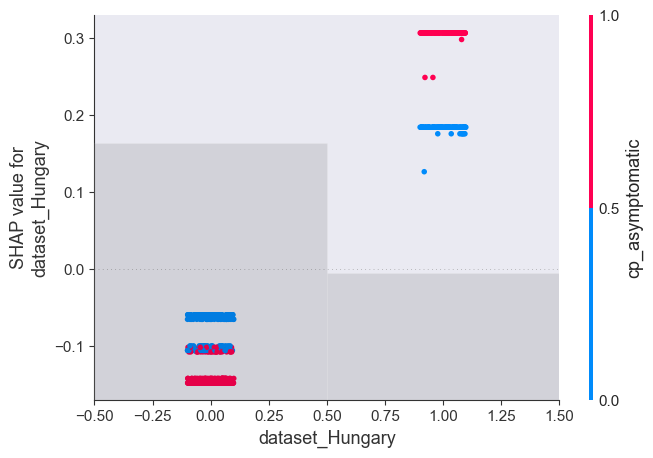

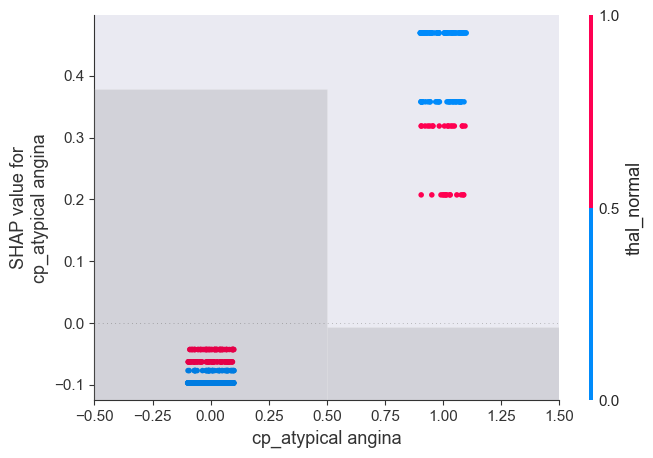

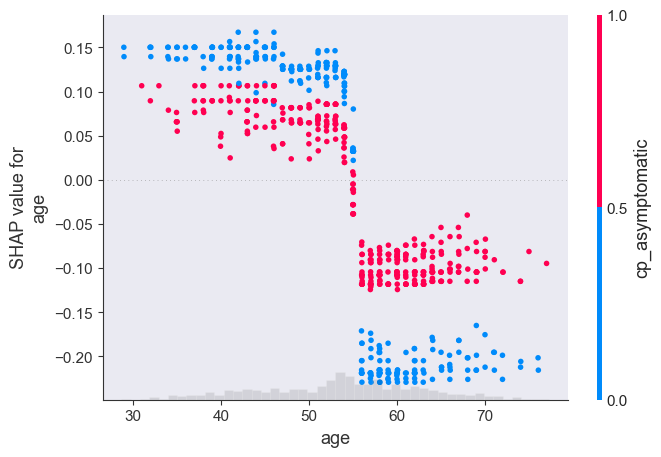

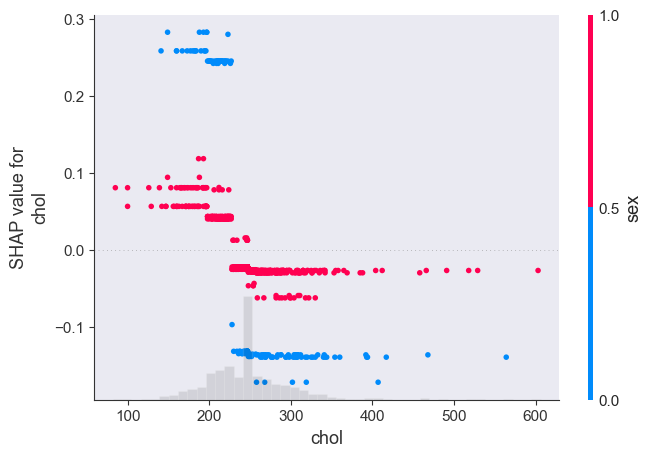

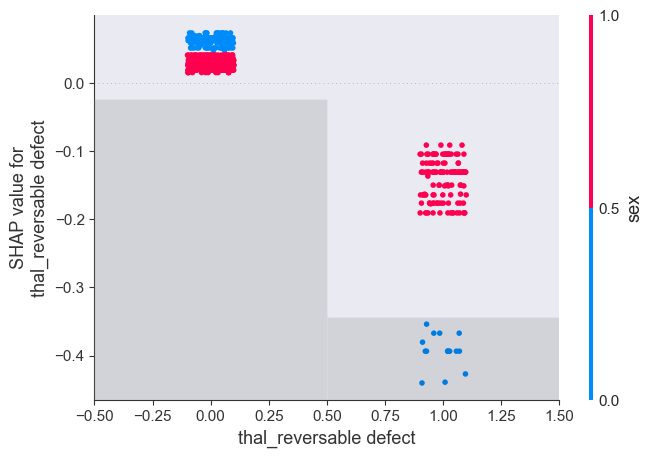

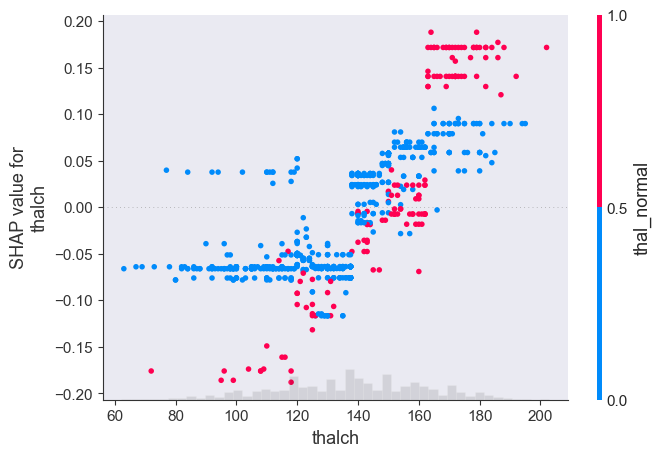

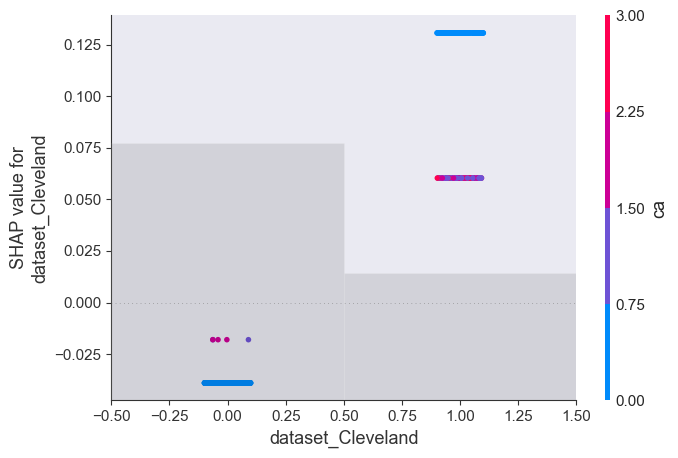

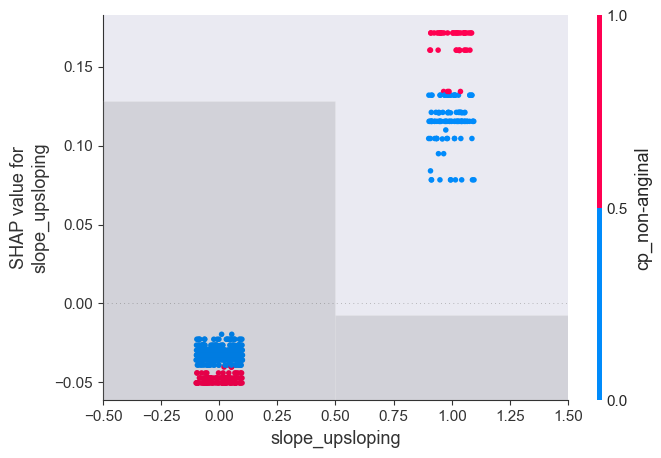

In [17]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
for feature in feature_importance_healthy[:15]:
    shap.plots.scatter(shap_values[:, feature, 0], color=shap_values[:, :, 0])

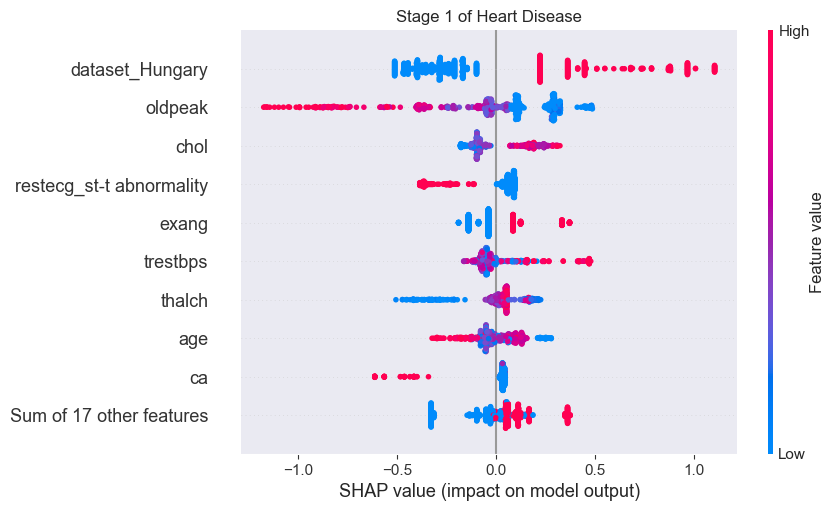

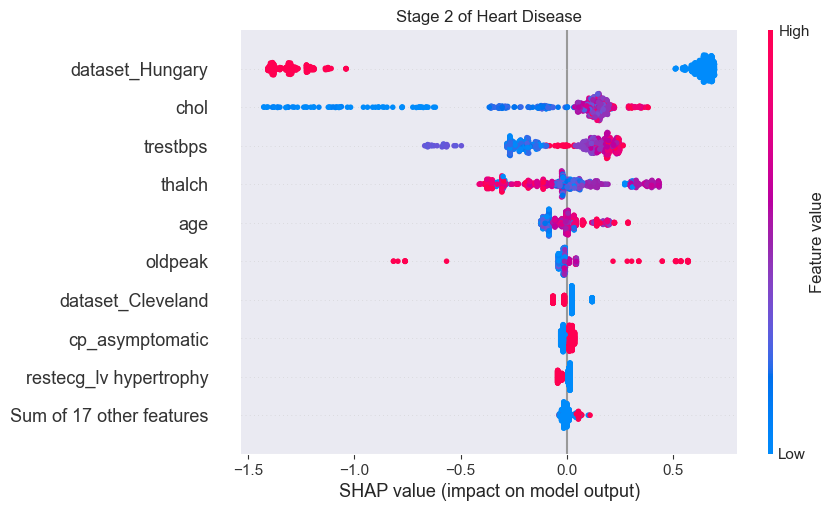

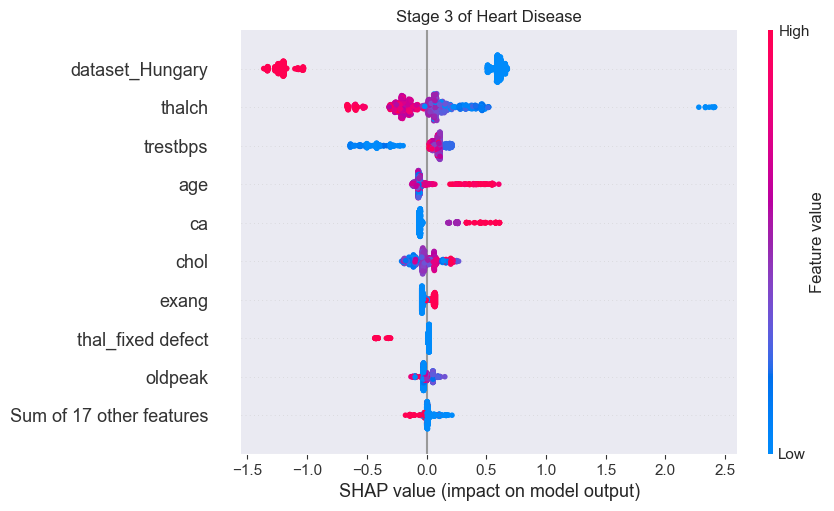

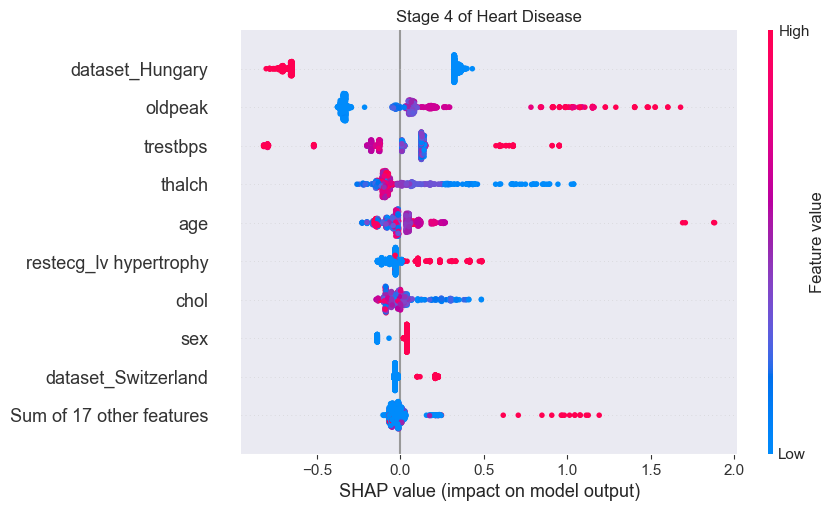

In [19]:
for i in range(4):
    plt.title(f'Stage {i+1} of Heart Disease')
    shap.plots.beeswarm(shap_values[:, :, i+1])

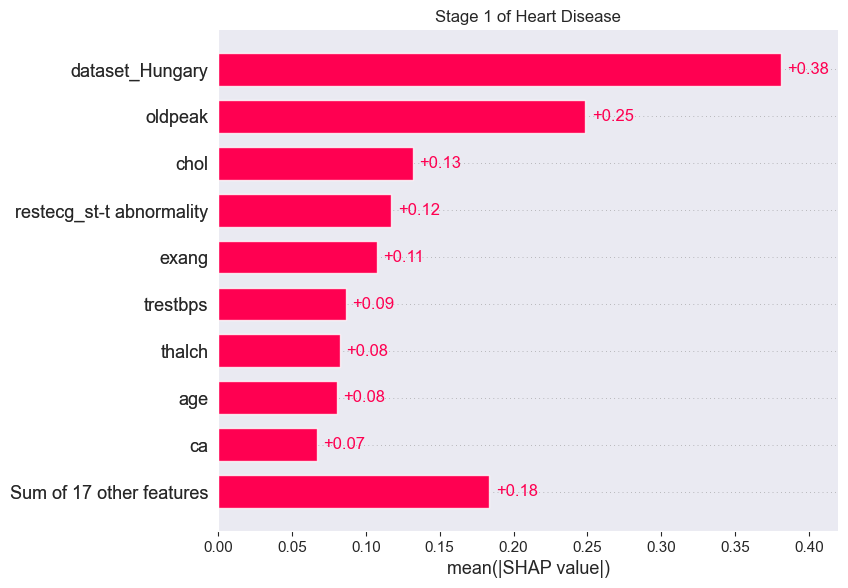

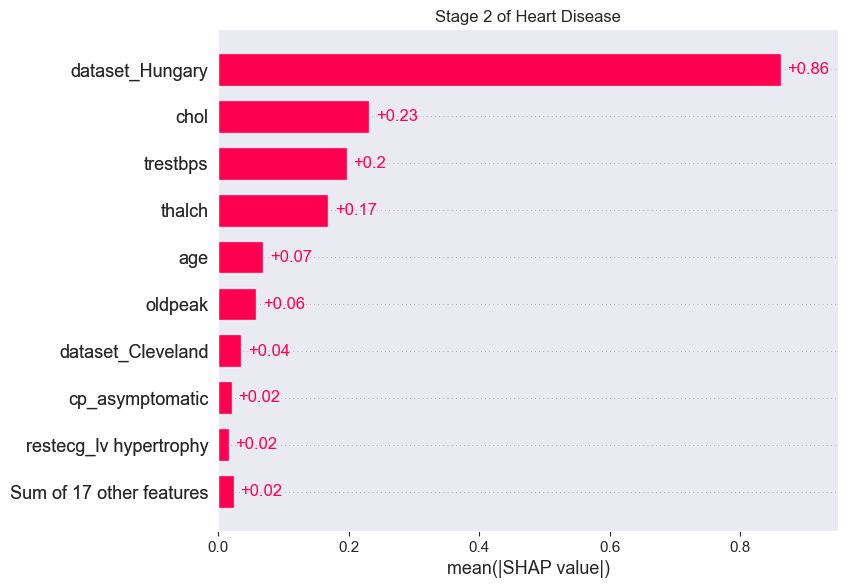

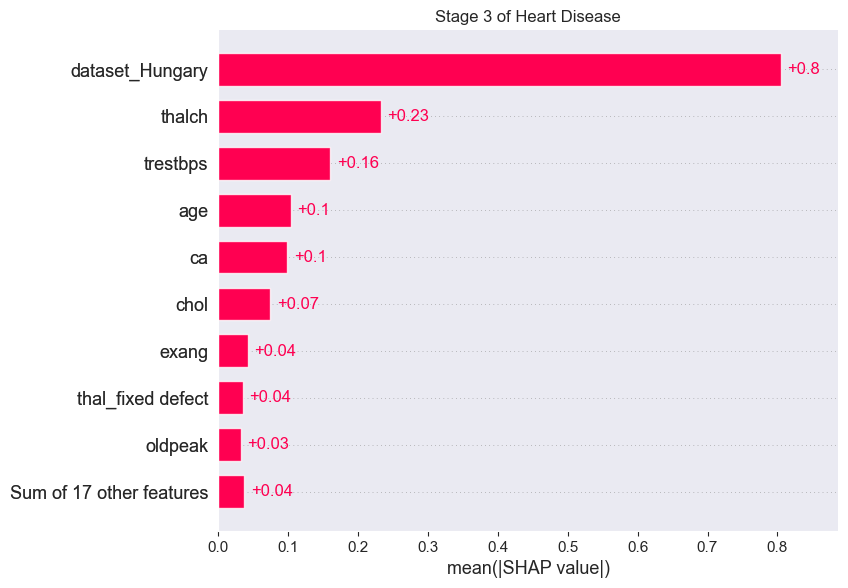

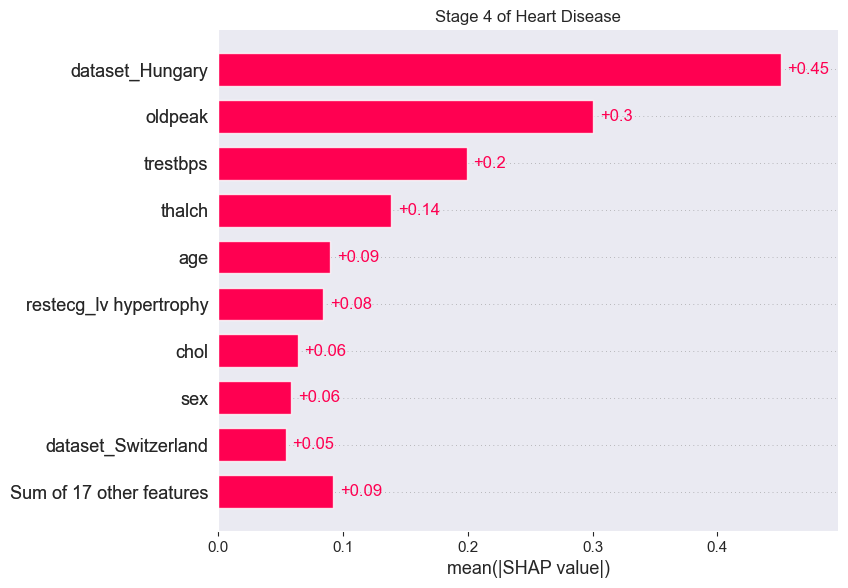

In [20]:
for i in range(4):
    plt.title(f'Stage {i+1} of Heart Disease')
    shap.plots.bar(shap_values[:, :, i+1])

In [21]:
shap_mean_ill = np.abs(shap_values[:, :, 1:].values).mean(2).mean(0)

ill_df = pd.DataFrame({'feature': feature_names, 'shap_mean': shap_mean_ill})
ill_df = ill_df.sort_values(by='shap_mean', ascending=False)
ill_df[:15]

,feature,shap_mean
10,dataset_Hungary,0.624486
2,trestbps,0.160677
7,oldpeak,0.159912
5,thalch,0.155493
3,chol,0.125434
0,age,0.085833
8,ca,0.051395
6,exang,0.040572
19,restecg_st-t abnormality,0.029669
17,restecg_lv hypertrophy,0.028839


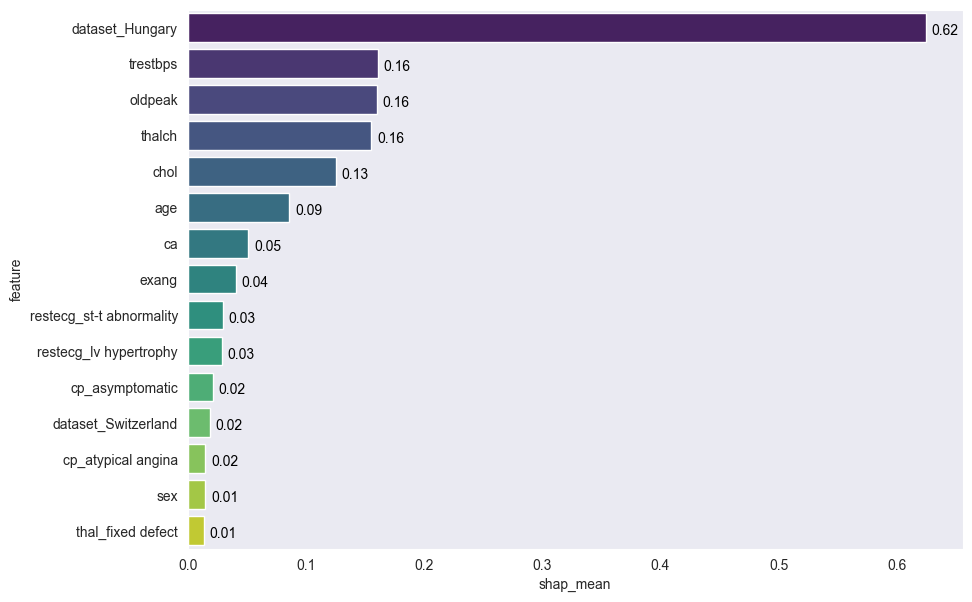

In [26]:
plt.figure(figsize=(10, 7))
ax = sns.barplot(ill_df[:15], y='feature', x='shap_mean', hue='feature', orient='h', palette='viridis', legend=False)

# Annotate each bar
for p, shap_m in zip(ax.patches, ill_df['shap_mean']):
    width = p.get_width() + 0.005
    ax.text(width, # X-coordinate for text
            p.get_y() + p.get_height() / 2. + 0.2, # Y-coordinate for text
            f'{shap_m:.2f}',                # Text to display
            fontsize=10,
            color='black')